<a href="https://colab.research.google.com/github/rajatrai30/fake-news-detection/blob/master/NLP_Project_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Exploring Fake News

In [15]:
fake_df = pd.read_csv('Fake.csv')
fake_df.head(10)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   
5   Racist Alabama Cops Brutalize Black Boy While...   
6   Fresh Off The Golf Course, Trump Lashes Out A...   
7   Trump Said Some INSANELY Racist Stuff Inside ...   
8   Former CIA Director Slams Trump Over UN Bully...   
9   WATCH: Brand-New Pro-Trump Ad Features So Muc...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   
5  The number of cases of cops brutalizing and ki...    News   
6  Donald Trump spent a good portion of his day a...    News   
7  In the wake of yet another court decision that...    News   
8  Many people have raised the alarm regarding th...    News   
9  Just when you might have thought we d get a br...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
5  December 25, 2017  
6  December 23, 2017  
7  December 23, 2017  
8  December 22, 2017  
9  December 21, 2017

In [16]:
#Counting by Subjects
for key,count in fake_df.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")

#Getting Total Rows
print(f"Total Rows:\t{fake_df.shape[0]}")

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Rows:	23481


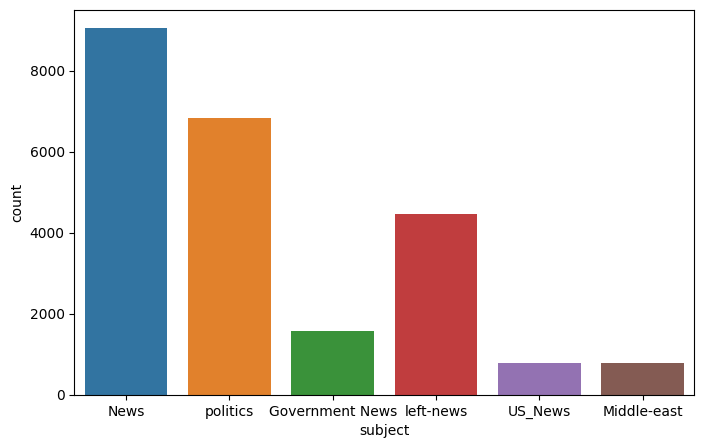

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(x="subject", data=fake_df)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


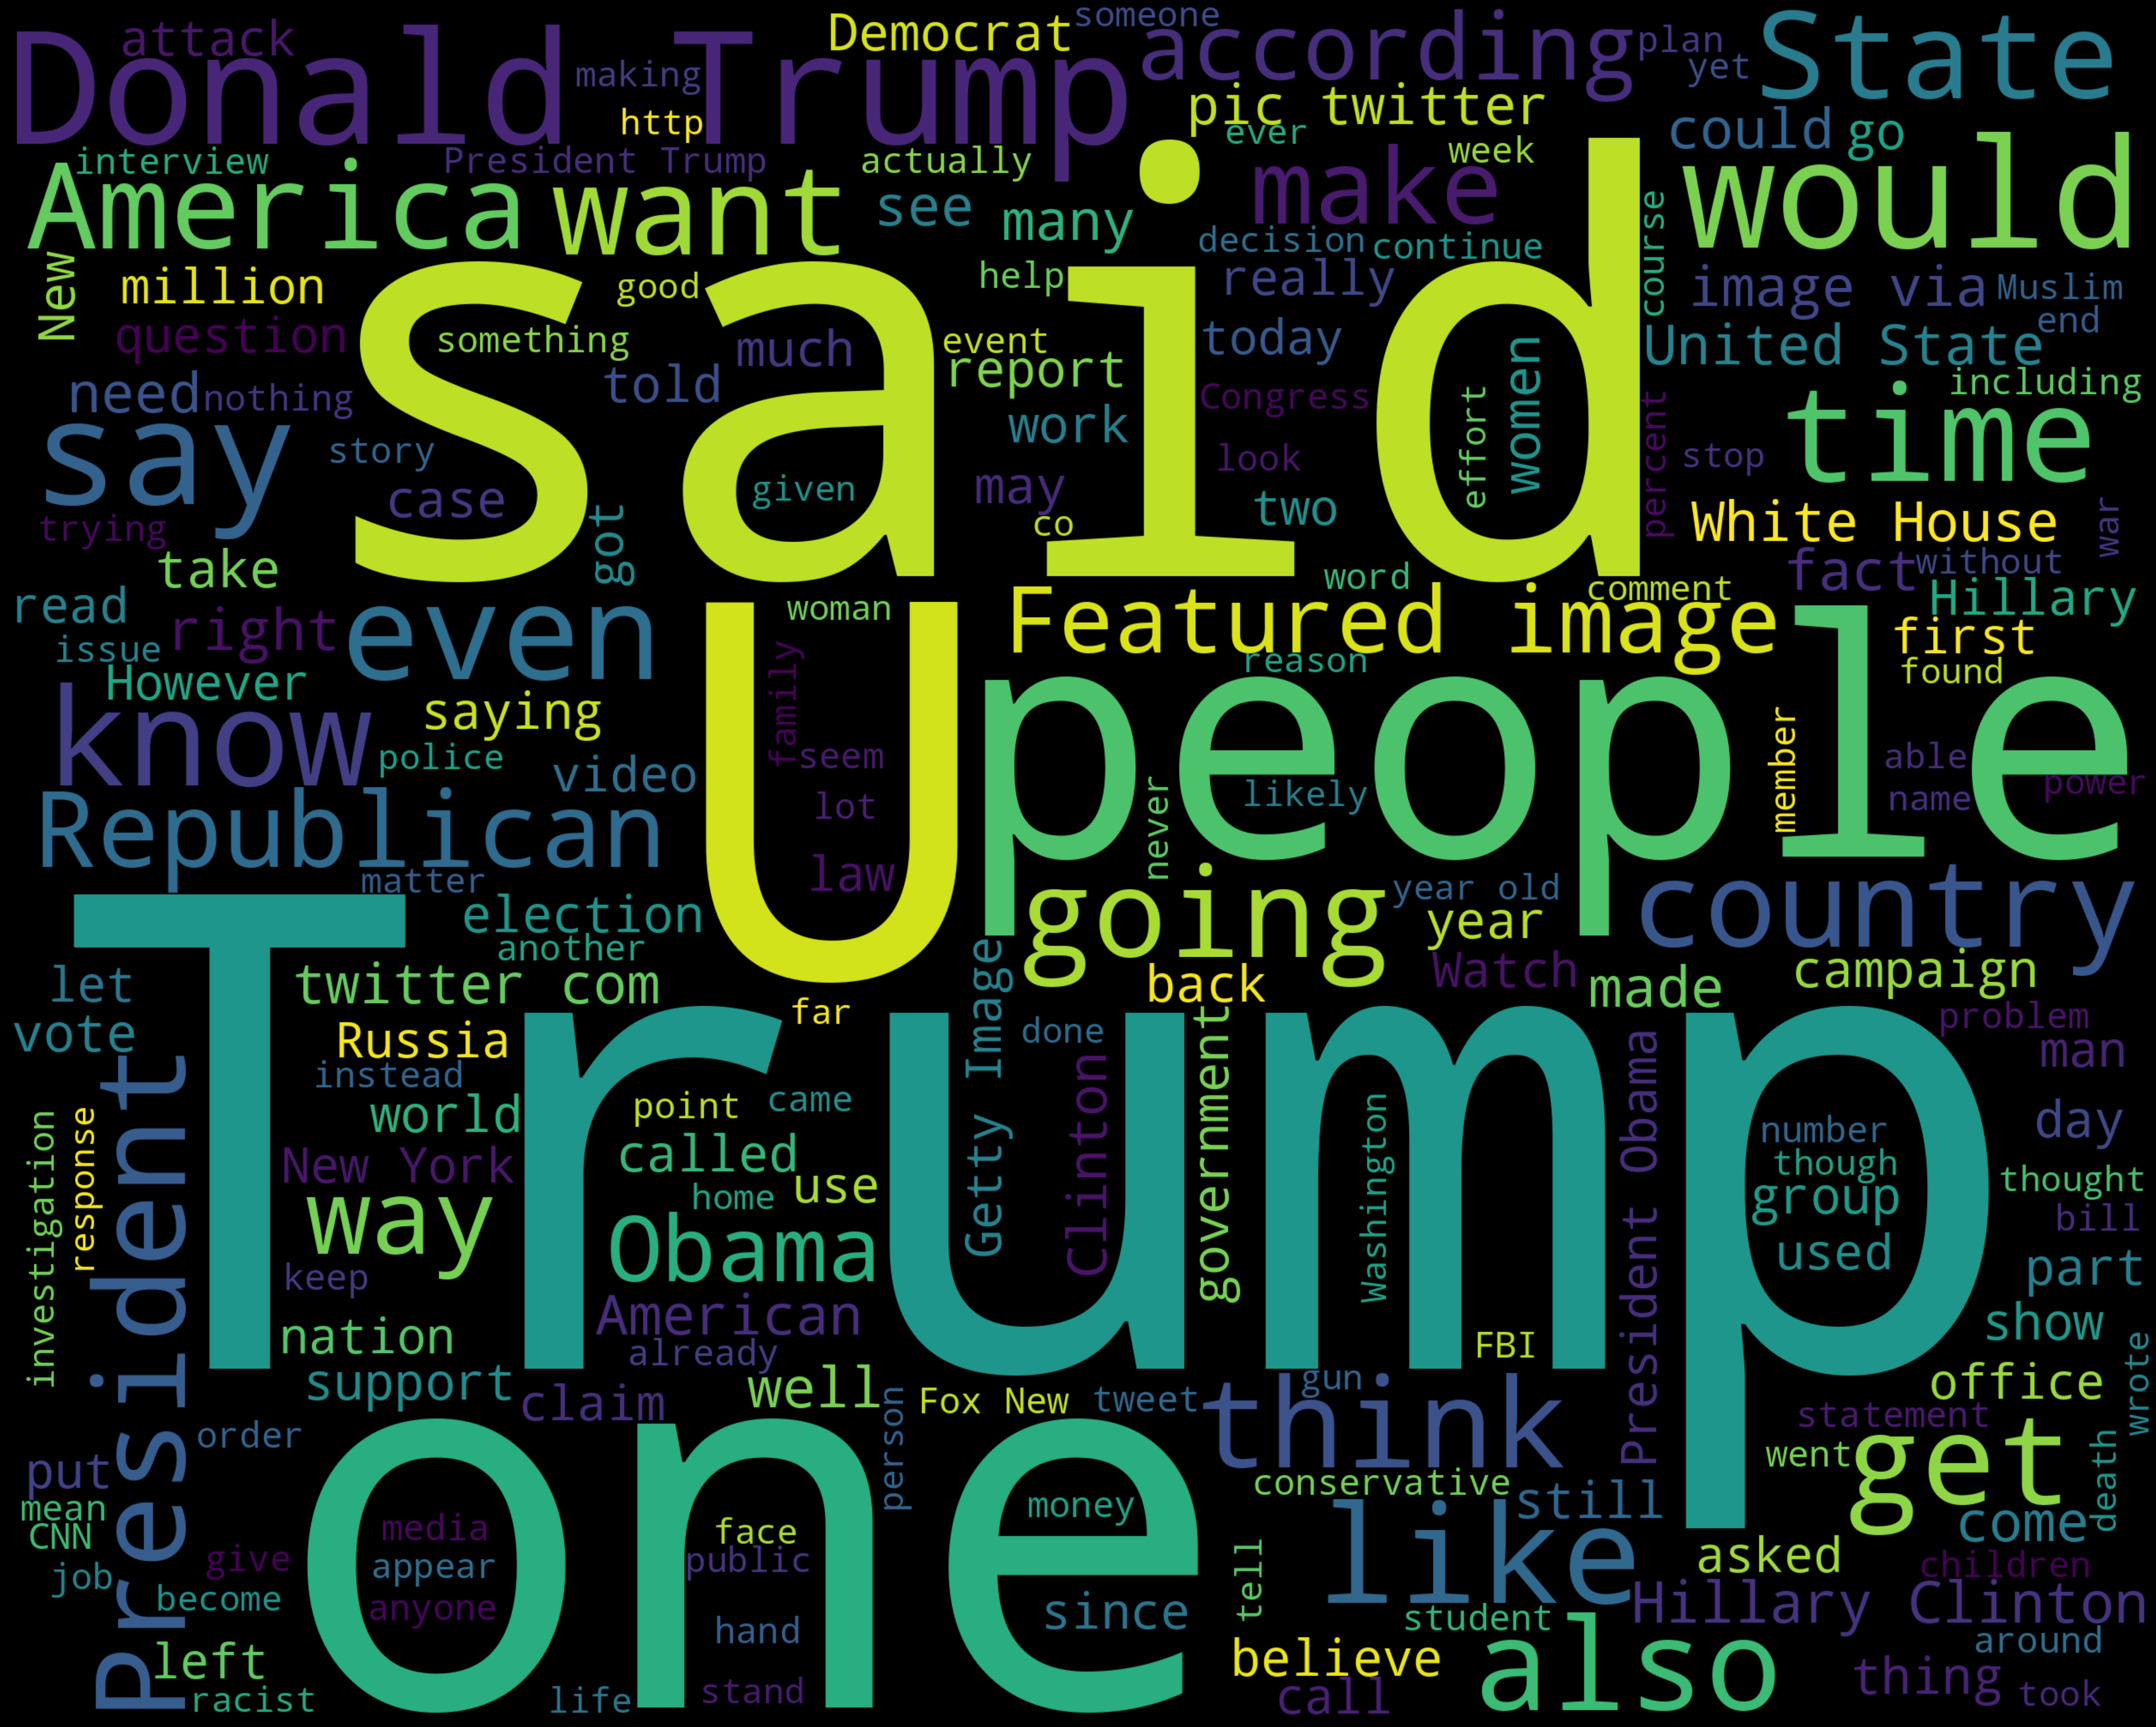

In [27]:
import nltk
nltk.download('stopwords')

#Word Cloud
text = ''
for news in fake_df.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 2500,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# Exploring Real news

In [28]:
real_df = pd.read_csv('True.csv')
real_df.head(10)

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   
5  White House, Congress prepare for talks on spe...   
6  Trump says Russia probe will be fair, but time...   
7  Factbox: Trump on Twitter (Dec 29) - Approval ...   
8         Trump on Twitter (Dec 28) - Global Warming   
9  Alabama official to certify Senator-elect Jone...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
5  WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...  politicsNews   
6  WEST PALM BEACH, Fla (Reuters) - President Don...  politicsNews   
7  The following statements were posted to the ve...  politicsNews   
8  The following statements were posted to the ve...  politicsNews   
9  WASHINGTON (Reuters) - Alabama Secretary of St...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   
5  December 29, 2017   
6  December 29, 2017   
7  December 29, 2017   
8  December 29, 2017   
9  December 28, 2017

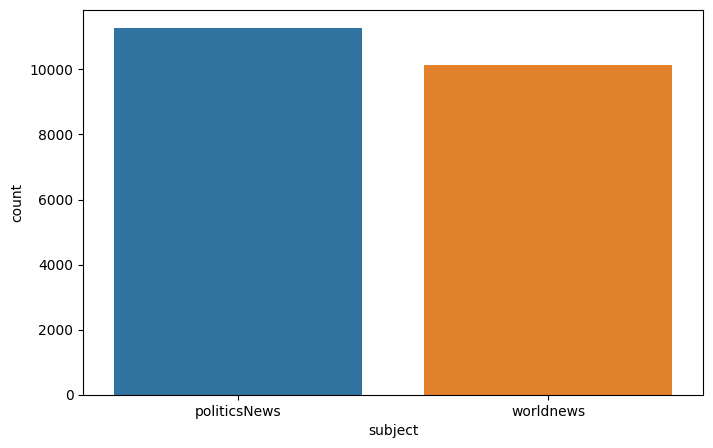

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(x="subject", data=real_df)
plt.show()

In [30]:
real_df.shape

(21417, 4)

### Difference in Text

Real news seems to have source of publication which is not present in fake news set

Looking at the data:

-Most of the text contains reuters information such as "WASHINGTON (Reuters)". <br>
-Some text are tweets from Twitter<br>
-Few text do not contain any publication info

# Data Cleaning

*Removing Reuters or Twitter Tweet information from the text*

*Text can be splitted only once at " - " which is always present after mentioning source of publication, this gives us publication part and text part<br>
*If we do not get text part, this means publication details was't given for that record<br>
*The Twitter tweets always have same source, a long text of max 259 characters

In [31]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(real_df.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [32]:
#Thus we have list of indices where publisher is not mentioned
#lets check
real_df.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

**Looks like, 8970 index does not have any text**

In [33]:
real_df.iloc[8970]
#yep empty
#will remove this soon

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [34]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(real_df.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)

        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [35]:
#Replace existing text column with new text
#add seperate column for publication info
real_df["publisher"] = publisher
real_df["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [36]:
real_df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0   The head of a conservative Republican faction...  politicsNews   
1   Transgender people will be allowed for the fi...  politicsNews   
2   The special counsel investigation of links be...  politicsNews   
3   Trump campaign adviser George Papadopoulos to...  politicsNews   
4   President Donald Trump called on the U.S. Pos...  politicsNews   

                 date                     publisher  
0  December 31, 2017           WASHINGTON (Reuters)  
1  December 29, 2017           WASHINGTON (Reuters)  
2  December 31, 2017           WASHINGTON (Reuters)  
3  December 30, 2017           WASHINGTON (Reuters)  
4  December 29, 2017   SEATTLE/WASHINGTON (Reuters)

In [37]:
 #checking for rows with empty text like row:8970
[index for index,text in enumerate(real_df.text.values) if str(text).strip() == '']
#seems only one :)

[8970]

In [38]:
#dropping this record
real_df.drop(8970, axis=0,inplace=True)

In [39]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake_df.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake_df.iloc[empty_fake_index].tail()

No of empty rows: 630


title text    subject  \
21816  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...       left-news   
21826  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...       left-news   
21827  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...       left-news   
21857  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...       left-news   
21873  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...       left-news   

               date  
21816  Apr 27, 2015  
21826  Apr 25, 2015  
21827  Apr 25, 2015  
21857  Apr 14, 2015  
21873  Apr 12, 2015

In [40]:
fake_df.drop(empty_fake_index, axis=0,inplace=True)

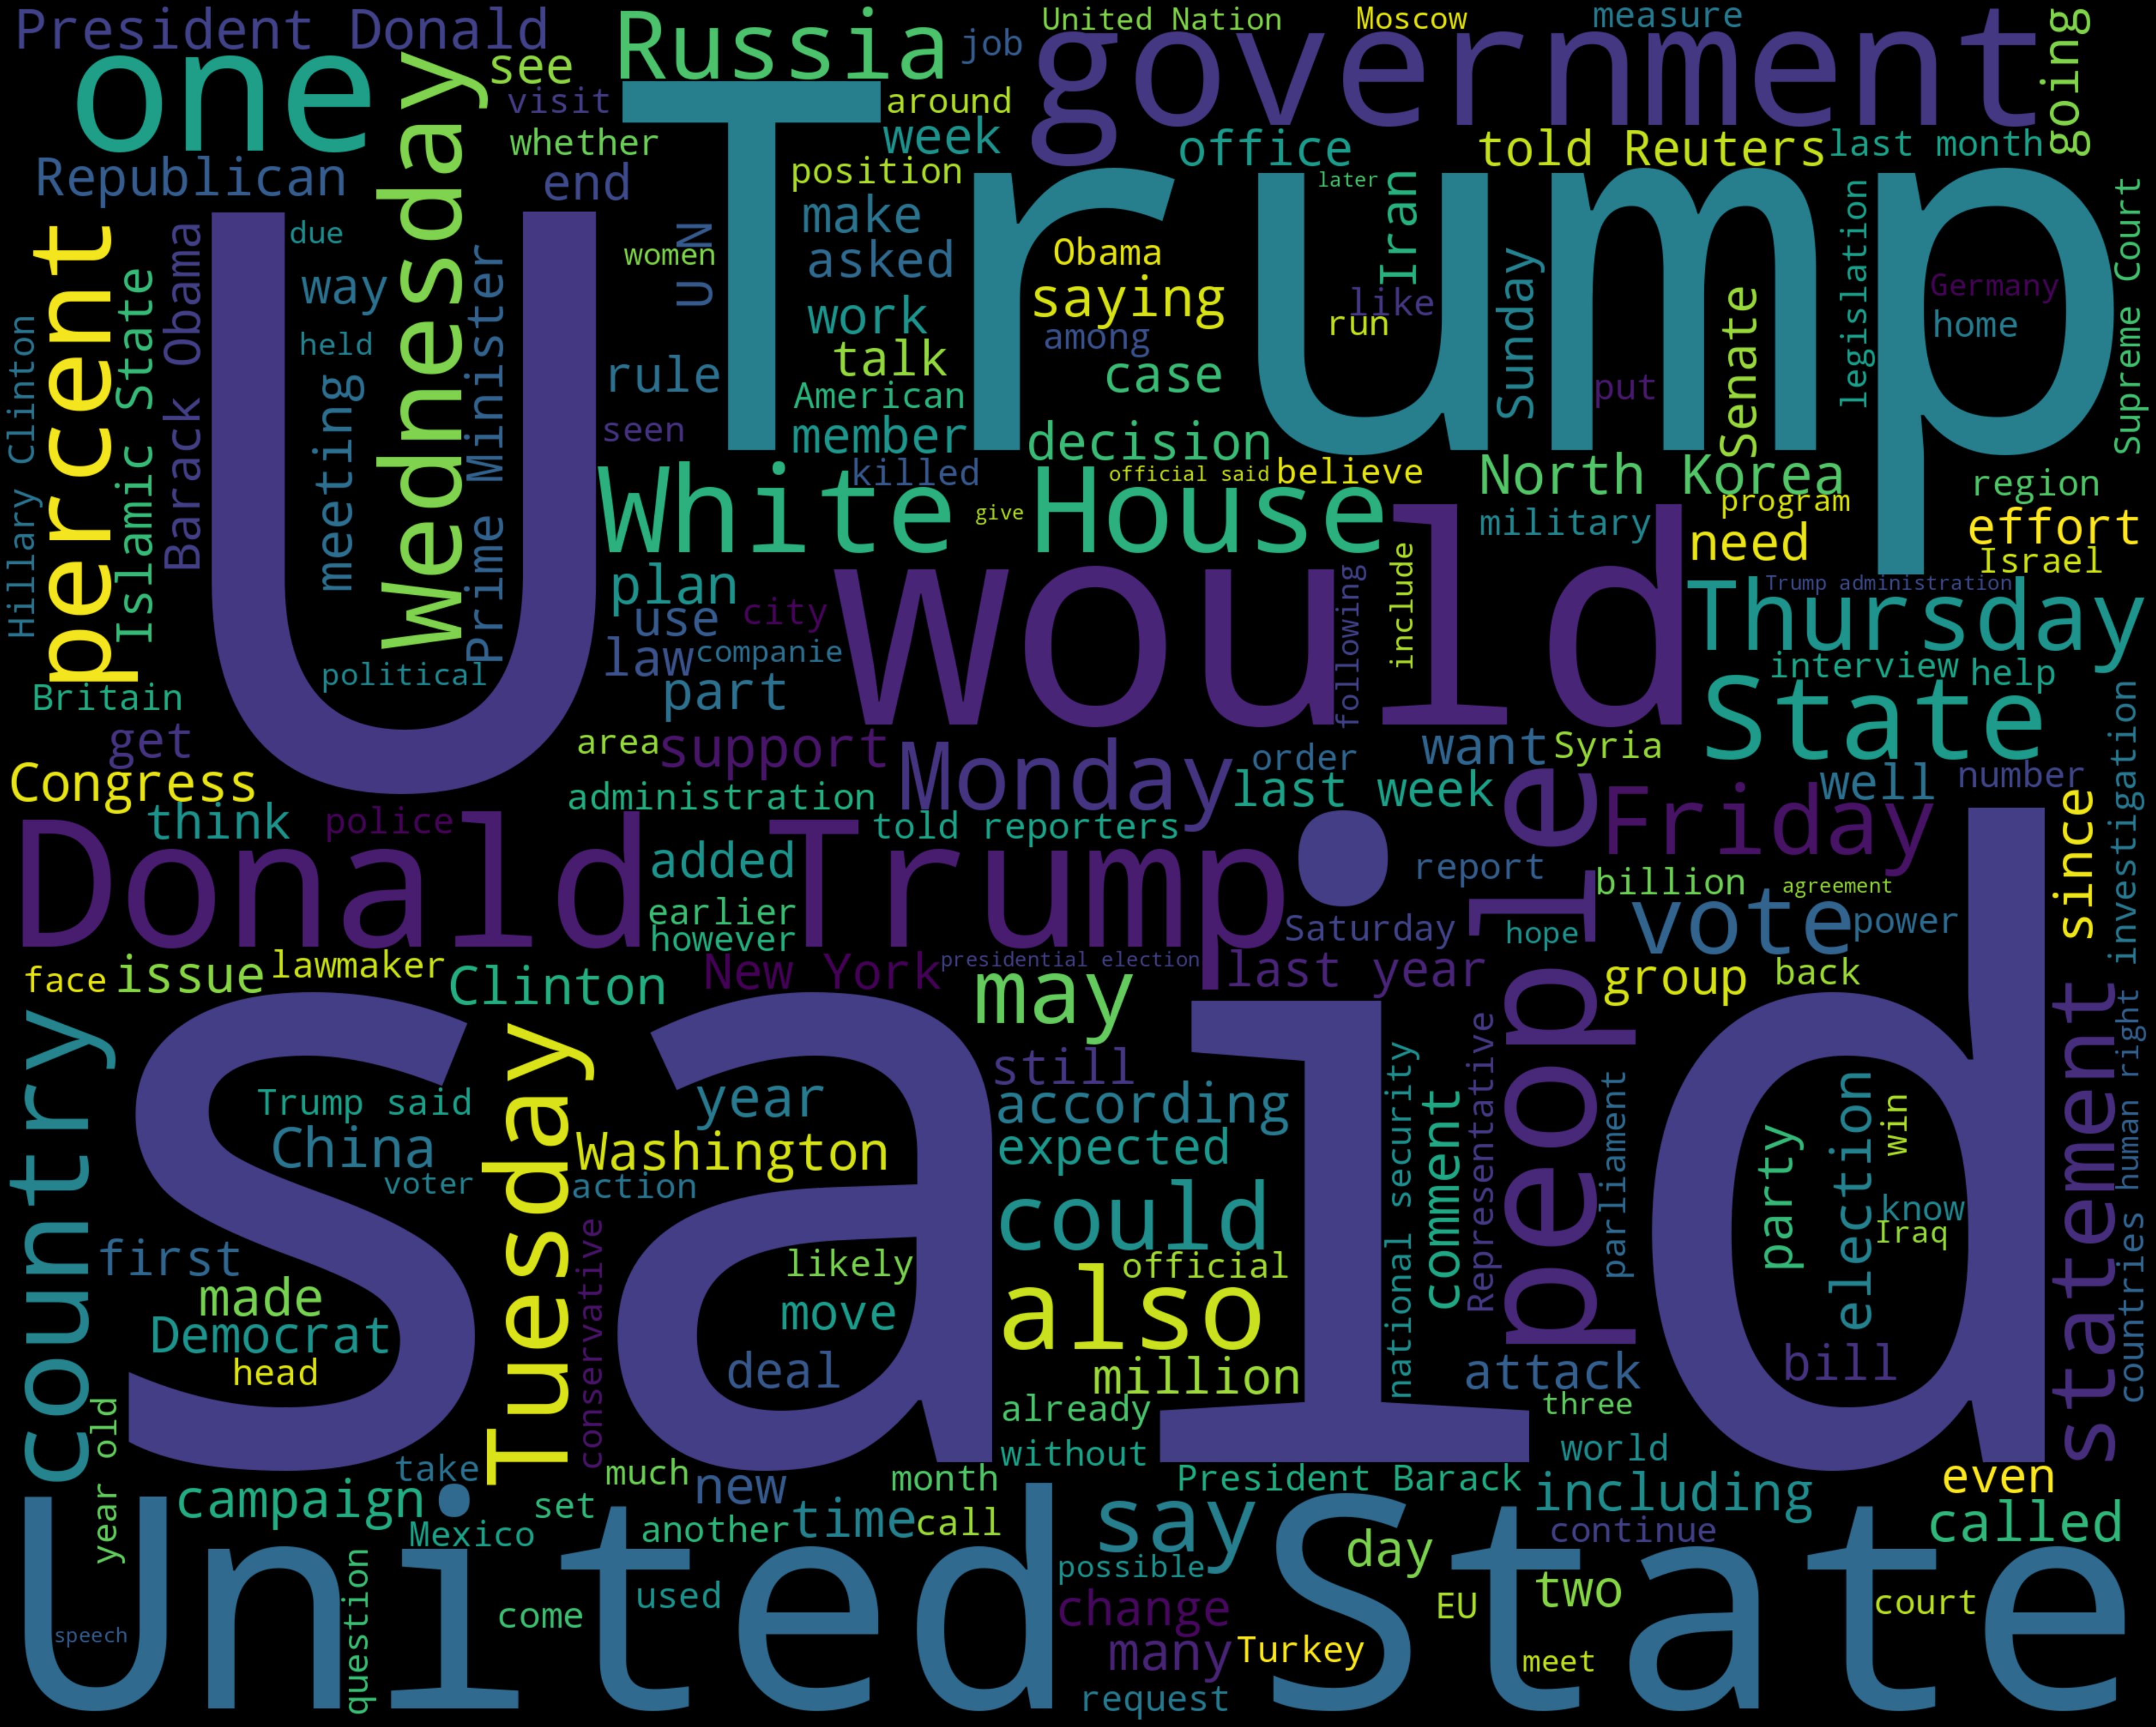

In [41]:
#WordCloud For Real News
text = ''
for news in real_df.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 2500,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# Preprocessing Text

In [42]:
# Adding class Information
real_df["class"] = 1
fake_df["class"] = 0

In [43]:
#Combining Title and Text
real_df["text"] = real_df["title"] + " " + real_df["text"]
fake_df["text"] = fake_df["title"] + " " + fake_df["text"]

In [44]:
# Subject is diffrent for real and fake thus dropping it
# And dropping Date, title and Publication Info of real
real_df = real_df.drop(["subject", "date","title",  "publisher"], axis=1)
fake_df = fake_df.drop(["subject", "date", "title"], axis=1)

In [45]:
real_df.head()

text  class
0  As U.S. budget fight looms, Republicans flip t...      1
1  U.S. military to accept transgender recruits o...      1
2  Senior U.S. Republican senator: 'Let Mr. Muell...      1
3  FBI Russia probe helped by Australian diplomat...      1
4  Trump wants Postal Service to charge 'much mor...      1

In [46]:
fake_df.head()

text  class
0   Donald Trump Sends Out Embarrassing New Year’...      0
1   Drunk Bragging Trump Staffer Started Russian ...      0
2   Sheriff David Clarke Becomes An Internet Joke...      0
3   Trump Is So Obsessed He Even Has Obama’s Name...      0
4   Pope Francis Just Called Out Donald Trump Dur...      0

In [47]:
#Combining both into new dataframe
df = real_df.append(fake_df, ignore_index=True)
del real_df, fake_df

In [48]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [49]:
y = df["class"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del df

In [50]:
X[:1]

[['budget',
  'fight',
  'looms',
  'republicans',
  'flip',
  'fiscal',
  'script',
  'head',
  'conservative',
  'republican',
  'faction',
  'congress',
  'voted',
  'month',
  'huge',
  'expansion',
  'national',
  'debt',
  'pay',
  'tax',
  'cuts',
  'called',
  'fiscal',
  'conservative',
  'sunday',
  'urged',
  'budget',
  'restraint',
  '2018',
  'keeping',
  'sharp',
  'pivot',
  'way',
  'among',
  'republicans',
  'representative',
  'mark',
  'meadows',
  'speaking',
  'cbs',
  'face',
  'nation',
  'drew',
  'hard',
  'line',
  'federal',
  'spending',
  'lawmakers',
  'bracing',
  'battle',
  'january',
  'return',
  'holidays',
  'wednesday',
  'lawmakers',
  'begin',
  'trying',
  'pass',
  'federal',
  'budget',
  'fight',
  'likely',
  'linked',
  'issues',
  'immigration',
  'policy',
  'even',
  'november',
  'congressional',
  'election',
  'campaigns',
  'approach',
  'republicans',
  'seek',
  'keep',
  'control',
  'congress',
  'president',
  'donald',
  'tru

In [51]:
y[:5]

array([1, 1, 1, 1, 1])

In [52]:
y[-5:]

array([0, 0, 0, 0, 0])

In [53]:
import gensim

### Vectorization -- Word2Vec
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

In [56]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [59]:
#vocab size
vocab_size = len(w2v_model.wv.index_to_key)
print("Vocabulary size:", vocab_size)
#We have now represented each of 122238 words by a 100dim vector.

Vocabulary size: 122238


In [62]:
#see a sample vector for random word, lets say House
vector = w2v_model.wv["house"]

# Print the vector
print("Vector for 'house':", vector)

Vector for 'house': [ 4.165308    1.5533888  -0.81998134 -1.0774162   1.4600942   0.12410735
 -2.5087202  -0.85167855 -0.19277589 -0.5869625  -0.24055475  3.7565196
 -0.59459734 -0.15359825  1.4350255  -1.2669535   1.1097332  -2.0234191
  2.5333695  -1.8823713  -3.3235438   0.05675481 -0.23760119 -1.3058316
 -5.4714804  -1.2254057  -4.1823616  -0.3006065  -2.4920037  -1.4211949
 -5.291096    1.0133828  -0.27014056 -0.27633524  3.797339   -1.662503
 -2.8107128   2.6412451  -1.3766898   2.7426739  -0.56120884  3.1901608
 -0.72314435 -0.93641686 -0.526234    2.5729764   4.6700754  -0.6402905
 -5.049054    0.16401468  1.1708903   1.9574366   1.2376121   1.2331051
 -1.6742018  -0.8058013   0.58079195  3.0491369  -2.7659655   0.30049896
 -0.9166298   1.3364841   2.4131021   2.3553736   1.9147913  -2.4641252
 -0.9729255  -0.6305505   0.5641574  -0.8472363  -1.2358041   1.8517175
 -0.08798032  0.97346085  0.06560182  2.141682   -2.7077973   0.72528905
  0.05611196  0.5114283   1.7529713   3.95

In [63]:
w2v_model.wv.most_similar("trump")

[('elect', 0.6303662061691284),
 ('cruz', 0.5712312459945679),
 ('course', 0.5103492736816406),
 ('conway', 0.5096203684806824),
 ('hillary', 0.4982076585292816),
 ('rumsfeld', 0.49573299288749695),
 ('actually', 0.48806798458099365),
 ('obama', 0.4837120473384857),
 ('kdmtphe7zouif', 0.4821833372116089),
 ('petty', 0.47368666529655457)]

In [64]:
w2v_model.wv.most_similar("america")

[('nation', 0.7098482847213745),
 ('country', 0.6800728440284729),
 ('american', 0.5569742918014526),
 ('us', 0.5539255142211914),
 ('intelligenti', 0.5271530747413635),
 ('world', 0.5245844125747681),
 ('americans', 0.5180409550666809),
 ('africa', 0.514689028263092),
 ('truly', 0.5142795443534851),
 ('planet', 0.5124219059944153)]

In [65]:
w2v_model.wv.most_similar("fbi")

[('comey', 0.7383531928062439),
 ('doj', 0.636052131652832),
 ('mueller', 0.6173150539398193),
 ('cia', 0.6163035035133362),
 ('investigators', 0.6117042303085327),
 ('investigation', 0.6080296039581299),
 ('dhs', 0.5506681799888611),
 ('nsa', 0.5362740159034729),
 ('nunes', 0.534767210483551),
 ('inquiry', 0.5310831665992737)]

In [66]:
w2v_model.wv.most_similar("google")

[('fb', 0.7663295865058899),
 ('alphabet', 0.7498942613601685),
 ('app', 0.6821705102920532),
 ('apple', 0.6818355321884155),
 ('microsoft', 0.6752996444702148),
 ('algorithms', 0.6750844717025757),
 ('content', 0.6734479665756226),
 ('googl', 0.6618357300758362),
 ('algorithm', 0.6609014868736267),
 ('reddit', 0.6546124815940857)]

In [67]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
#First was Bush

[('elect', 0.5413180589675903),
 ('bush', 0.5402911305427551),
 ('cruz', 0.538411557674408),
 ('incoming', 0.5087273716926575),
 ('hillary', 0.49575167894363403),
 ('clintons', 0.4613712430000305),
 ('actually', 0.4605264365673065),
 ('crooked', 0.4583949148654938),
 ('course', 0.45822563767433167),
 ('conway', 0.44901043176651)]

These Vectors will be passed to LSTM/GRU instead of words. 1D-CNN can further be used to extract features from the vectors.

Keras has implementation called **"Embedding Layer"** which would create word embeddings(vectors). Since we did that with gensim's word2vec, we will load these vectors into embedding layer and make the layer non-trainable.

We cannot pass string words to embedding layer, thus need some way to represent each words by numbers.

Tokenizer can represent each word by number

In [68]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it to lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [69]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[389, 395, 10493, 54, 5505, 1285, 4840, 315, 205, 16]

In [70]:
#Lets check few word to numerical reprsentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
also -> 9
obama -> 10


**Notice it starts with 1**

We can pass numerical representation of words into neural network.

We can use Many-To-One (Sequence-To-Word) Model of RNN, as we have many words in news as input and one output ie Probability of being Real.

For Many-To-One model, lets use a fixed size input

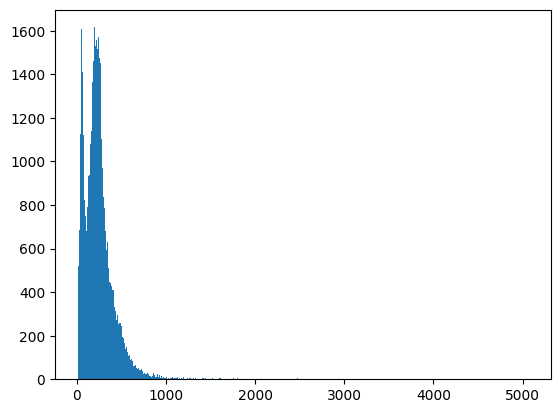

In [71]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :)

In [72]:
len(y)

44267

In [73]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
## Out of 44k news, 43k have less than 700 words

43352

In [74]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [75]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [76]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [77]:
vocab_size

122239

In [78]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

We Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer

Embedding layer accepts numecical-token of word and outputs corresponding vercor to inner layer.

It sends vector of zeros to next layer for unknown words which would be tokenized to 0.

Input length of Embedding Layer is the length of each news (700 now due to padding and truncating)

In [81]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
# embedding_vectors = get_weight_matrix(w2v_model, word_index)
def get_weight_matrix(model, vocab):
    # Initialize the weight matrix with zeros
    weight_matrix = np.zeros((len(vocab) + 1, model.vector_size))  # +1 for the zero padding index

    # Iterate over the words in the vocabulary and store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if word in model.wv:
            weight_matrix[i] = model.wv[word]

    return weight_matrix

In [83]:
#Defining Neural Network
# Generate embedding vectors using your get_weight_matrix function
embedding_vectors = get_weight_matrix(w2v_model, word_index)

# Define your neural network model
model = Sequential()
# Non-trainable embedding layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
# LSTM
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [84]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          12223900  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 12341277 (47.08 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 12223900 (46.63 MB)
_________________________________________________________________


In [85]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [86]:
model.fit(X_train, y_train, validation_split=0.3, epochs=7)

Epoch 1/7
727/727 [==============================] - 803s 1s/step - loss: 0.1243 - acc: 0.9555 - val_loss: 0.0994 - val_acc: 0.9689
Epoch 2/7
727/727 [==============================] - 830s 1s/step - loss: 0.0571 - acc: 0.9802 - val_loss: 0.0713 - val_acc: 0.9752
Epoch 3/7
727/727 [==============================] - 812s 1s/step - loss: 0.0423 - acc: 0.9856 - val_loss: 0.0587 - val_acc: 0.9805
Epoch 4/7
727/727 [==============================] - 818s 1s/step - loss: 0.0329 - acc: 0.9889 - val_loss: 0.0418 - val_acc: 0.9870
Epoch 5/7
727/727 [==============================] - 814s 1s/step - loss: 0.0163 - acc: 0.9945 - val_loss: 0.0424 - val_acc: 0.9883
Epoch 6/7
727/727 [==============================] - 787s 1s/step - loss: 0.0121 - acc: 0.9960 - val_loss: 0.0346 - val_acc: 0.9911
Epoch 7/7
727/727 [==============================] - 780s 1s/step - loss: 0.0073 - acc: 0.9978 - val_loss: 0.0326 - val_acc: 0.9909


In [87]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

346/346 [==============================] - 107s 308ms/step


In [88]:
accuracy_score(y_test, y_pred)

0.9915062799313273

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5706
           1       0.99      0.99      0.99      5361

    accuracy                           0.99     11067
   macro avg       0.99      0.99      0.99     11067
weighted avg       0.99      0.99      0.99     11067



In [90]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[5651,   55],
       [  39, 5322]])

Text(95.72222222222221, 0.5, 'Truth')

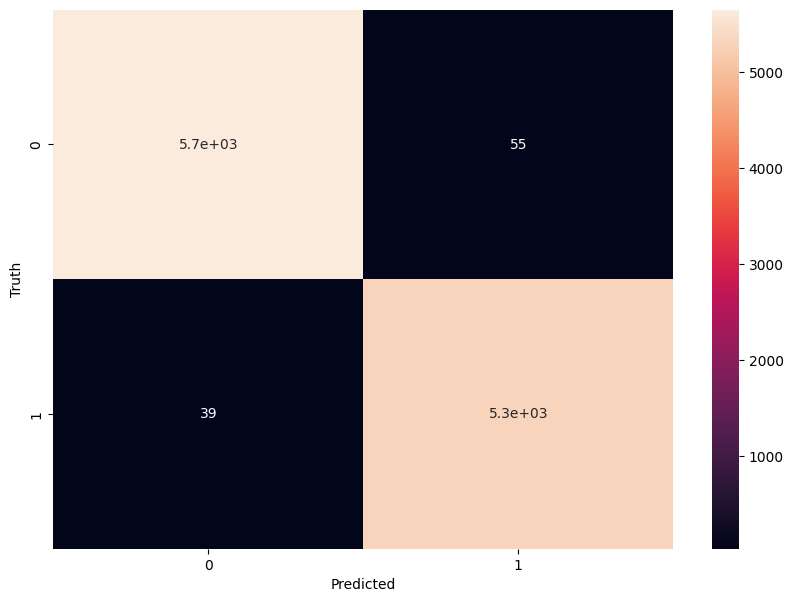

In [91]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [92]:
del model

In [93]:
#invoke garbage collector to free ram
import gc
gc.collect()

2279

### Comments
99% Accuracy looks like unusual. But model is developed carefully to avoid overfitting. As well as, removed some specific word to avoid biasness(Reuters..). I think, it's the problem of dataset which may have some indicator which leads to high accuracy. So, it's not guranteed that this model may not work up to the marks for another new dataset.

#### Important Notes

Datasete is collected from [Kaggle](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset/download)  <br>
Model developed by [Rajat Rai](https://rajat.engineer/)